Learning to Learn - John Tomlinson, Ahan Maurya, Dr. Jing Wang

First we need to import the modules we created for this notebook

In [1]:
import meta_network
import original_network
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [2]:
# Reload to pick up on-disk changes to original_network
import importlib
importlib.reload(original_network)
importlib.reload(meta_network)

<module 'meta_network' from 'c:\\Users\\bobtt\\OneDrive\\Desktop\\Documents\\JackCS\\learning-to-learn\\cartpole-implementation\\meta_network.py'>

In [3]:
# Reproducibility helpers
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

We will start by initializing both of our networks

In [4]:
cartpole_network, cartpole_target_network,memory, optimizer, device, env = original_network.build_model()

Now lets build a function to graph our reward over time

In [5]:
def plot_rewards(reward_list):
    plt.plot(reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Time')
    plt.scatter(range(len(reward_list)), reward_list, marker='o', color='blue')
    plt.show()


Lets make a training loop to get our baseline performance for our model wihtout the meta learning

In [22]:
NUM_EPISODES = 300
TARGET_UPDATE = 10
MAX_STEPS_PER_EPISODE = 500

In [ ]:
def training_loop(
    episodes,
    max_steps=500,
    epsilon_start=0.9,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    meta_batch_size=128,
    target_update_interval=TARGET_UPDATE,
    seed=None,
    record_states=False,
 ):
    total_reward_list = []
    episodes_states = []
    epsilon = epsilon_start
    best_reward = -np.inf
    global_step = 0

    for episode in range(episodes):
        reset_seed = None if seed is None else seed + episode  
        state, _ = env.reset(seed=reset_seed)
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0.0
        episode_states = [] if record_states else None
        step_count = 0

        while not done and step_count < max_steps:
            action = original_network.select_action(processed_state, cartpole_network, device, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            processed_next_state = original_network.process_state(next_state)

            memory.push(processed_state, action, reward, processed_next_state, done)

            if record_states:
                episode_states.append(next_state)

            processed_state = processed_next_state
            total_reward += reward
            step_count += 1
            global_step += 1

            
            original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)

            if global_step % target_update_interval == 0:
                original_network.update_target_network(cartpole_network, cartpole_target_network)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        total_reward_list.append(total_reward)

        if record_states and episode_states:
            episodes_states.append(np.array(episode_states))

        if total_reward > best_reward:
            best_reward = total_reward

        window = min(len(total_reward_list), 50)
        moving_avg = np.mean(total_reward_list[-window:]) if window else total_reward
        print(
            f"Episode {episode+1}/{episodes} | Reward: {total_reward:.1f} | Moving Avg ({window}): {moving_avg:.1f} | Epsilon: {epsilon:.3f}"
        )

    if record_states:
        return total_reward_list, episodes_states
    return total_reward_list

Episode 1/300 | Reward: 36.0 | Moving Avg (1): 36.0 | Epsilon: 0.895
Episode 2/300 | Reward: 25.0 | Moving Avg (2): 30.5 | Epsilon: 0.891
Episode 3/300 | Reward: 14.0 | Moving Avg (3): 25.0 | Epsilon: 0.887
Episode 4/300 | Reward: 28.0 | Moving Avg (4): 25.8 | Epsilon: 0.882
Episode 5/300 | Reward: 22.0 | Moving Avg (5): 25.0 | Epsilon: 0.878
Episode 6/300 | Reward: 27.0 | Moving Avg (6): 25.3 | Epsilon: 0.873
Episode 7/300 | Reward: 19.0 | Moving Avg (7): 24.4 | Epsilon: 0.869
Episode 8/300 | Reward: 19.0 | Moving Avg (8): 23.8 | Epsilon: 0.865
Episode 9/300 | Reward: 15.0 | Moving Avg (9): 22.8 | Epsilon: 0.860
Episode 10/300 | Reward: 14.0 | Moving Avg (10): 21.9 | Epsilon: 0.856
Episode 11/300 | Reward: 15.0 | Moving Avg (11): 21.3 | Epsilon: 0.852
Episode 12/300 | Reward: 16.0 | Moving Avg (12): 20.8 | Epsilon: 0.847
Episode 13/300 | Reward: 28.0 | Moving Avg (13): 21.4 | Epsilon: 0.843
Episode 14/300 | Reward: 15.0 | Moving Avg (14): 20.9 | Epsilon: 0.839
Episode 15/300 | Reward:

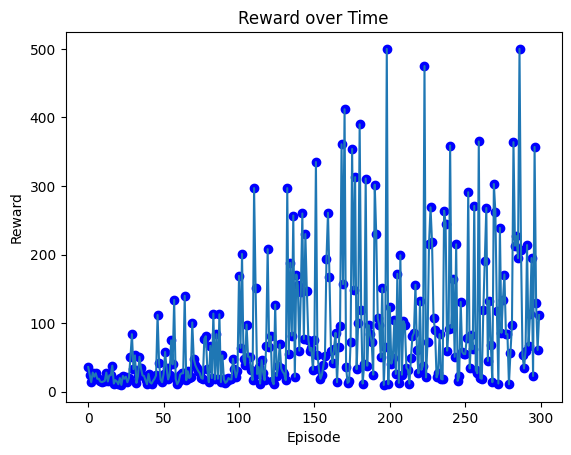

In [24]:
rewards, episodes_states = training_loop(
    NUM_EPISODES,
    record_states=True,
    max_steps=MAX_STEPS_PER_EPISODE,
    seed=SEED,
 )
plot_rewards(rewards)

In [9]:
def compute_state_stats(episodes_states):
    stats = {
        'best_x': [],         
        'avg_x': [],           
        'best_angle': [],      
        'avg_angle': [],       
        'best_x_vel': [],      
        'avg_x_vel': [],       
        'best_angle_vel': [],  
        'avg_angle_vel': []    
    }
   
    for episode_states in episodes_states:

        stats['best_x'].append(np.min(np.abs(episode_states[:, 0])))
        stats['avg_x'].append(np.mean(np.abs(episode_states[:, 0])))

        stats['best_angle'].append(np.min(np.abs(episode_states[:, 2])))
        stats['avg_angle'].append(np.mean(np.abs(episode_states[:, 2])))

        stats['best_x_vel'].append(np.min(np.abs(episode_states[:, 1])))
        stats['avg_x_vel'].append(np.mean(np.abs(episode_states[:, 1])))
        stats['best_angle_vel'].append(np.min(np.abs(episode_states[:, 3])))
        
        stats['avg_angle_vel'].append(np.mean(np.abs(episode_states[:, 3])))
   
    return {k: np.array(v) for k, v in stats.items()}



def plot_state_metric(metric_values, metric_name, color='steelblue'):


    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(metric_values, color=color, linewidth=1.5, label='Metric')
    ax.scatter(range(len(metric_values)), metric_values, marker='o', color=color, s=20, alpha=0.6)
    ax.set_xlabel('Episode')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} over Time')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_state_metrics_all(state_stats):

    metrics = [
        ('best_x', 'Min |Cart Position|'),
        ('avg_x', 'Avg |Cart Position|'),
        ('best_angle', 'Min |Pole Angle|'),
        ('avg_angle', 'Avg |Pole Angle|'),

        ('best_x_vel', 'Min |Cart Velocity|'),
        ('avg_x_vel', 'Avg |Cart Velocity|'),
        ('best_angle_vel', 'Min |Pole Velocity|'),
        ('avg_angle_vel', 'Avg |Pole Velocity|')
    ]
   
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
   
    for idx, (key, title) in enumerate(metrics):
        ax = axes[idx]
        values = state_stats[key]

        ax.plot(values, color='steelblue', linewidth=1.5)
        ax.scatter(range(len(values)), values, marker='o', color='steelblue', s=15, alpha=0.6)

        ax.set_xlabel('Episode')
        ax.set_ylabel(title)

        ax.set_title(title)

        ax.grid(True, alpha=0.3)
   
    plt.tight_layout()
    plt.show()

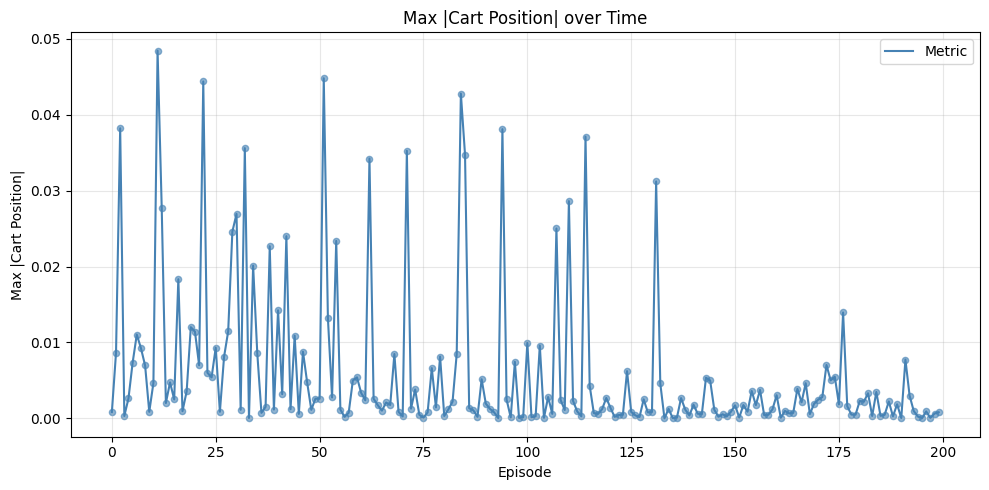

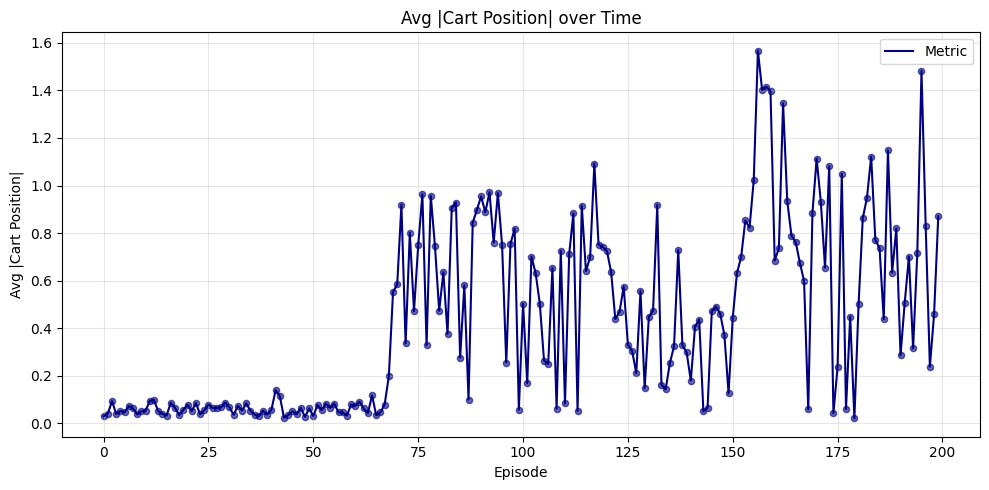

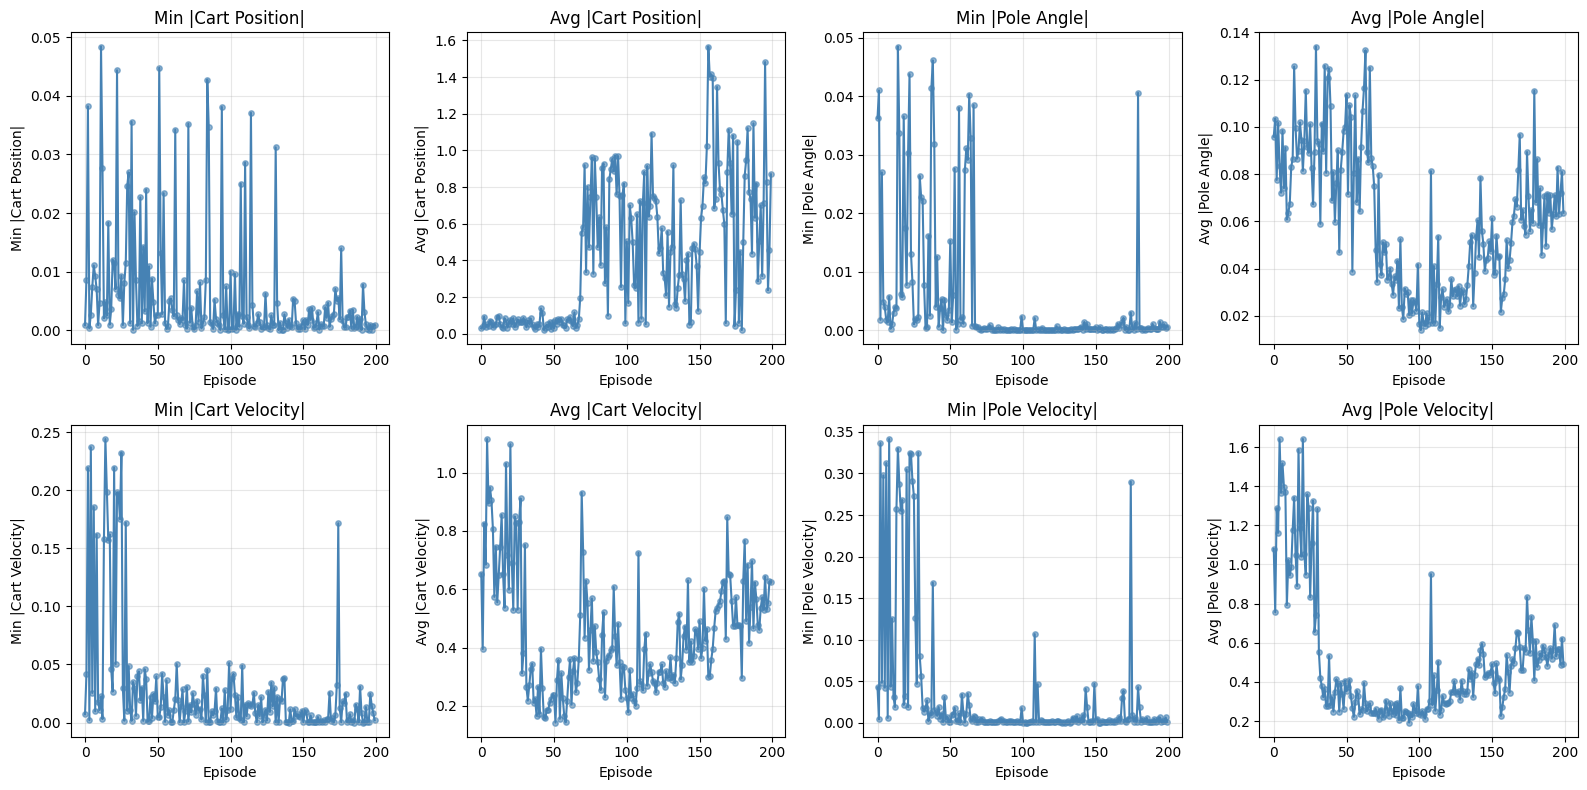

In [10]:

stats = compute_state_stats(episodes_states)


plot_state_metric(stats['best_x'], 'Max |Cart Position|', color='steelblue')
plot_state_metric(stats['avg_x'], 'Avg |Cart Position|', color='navy')


plot_state_metrics_all(stats)


Now that we have a baseline for our reinforcenet learning loop we can try training with our met network that will automatically shape our network.

In [11]:
meta_input_dim = cartpole_network.fc1.in_features + 2  # state features + action + reward context
meta_network_test, meta_memory = meta_network.build_model(meta_input_dim)

In [12]:
#new networks
cartpole_network2, cartpole_target_network2,memory2, optimizer2, device2, env2 = original_network.build_model()

In [20]:
def training_loop_meta(
    episodes,
    max_steps=500,
    epsilon_start=0.9,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    meta_batch_size=128,
    target_update_interval=TARGET_UPDATE,
    seed=None,
 ):
    total_reward_list = []
    epsilon = epsilon_start
    best_reward = -np.inf
    action_trace = []
    global_step = 0
    saved_model = False

    for episode in range(episodes):
        reset_seed = None if seed is None else seed + episode
        state, _ = env2.reset(seed=reset_seed)
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0.0
        step_count = 0
        episode_meta_features = []

        while not done and step_count < max_steps:
            action = original_network.select_action(processed_state, cartpole_network2, device2, epsilon, env2)
            next_state, reward, terminated, truncated, _ = env2.step(action)
            done = terminated or truncated
            processed_next_state = original_network.process_state(next_state)

            shaped_reward, meta_features = meta_network.select_action(
                processed_state,
                action,
                reward,
                meta_network_test,
                device,
                epsilon,
                meta_input_dim,
                return_features=True,
            )

            total_shaped_reward = reward + shaped_reward
            memory2.push(processed_state, action, total_shaped_reward, processed_next_state, done)
            episode_meta_features.append(meta_features)
            action_trace.append(shaped_reward)

            processed_state = processed_next_state
            step_count += 1
            global_step += 1
            total_reward += reward

            original_network.optimize_model(cartpole_network2, cartpole_target_network2, memory2, optimizer2, device2)

            if global_step % target_update_interval == 0:
                original_network.update_target_network(cartpole_network2, cartpole_target_network2)

        meta_reward_data = meta_network.sliding_window(total_reward_list + [total_reward], 50)
        meta_reward_signal = float(meta_network.compute_reward(meta_reward_data))

        if episode_meta_features:
            for features in episode_meta_features:
                meta_memory.push(features, meta_reward_signal)
            meta_network.optimize_model(meta_network_test, meta_memory, device, batch_size=meta_batch_size)

        total_reward_list.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if total_reward > best_reward:
            best_reward = total_reward
        
        if total_reward == 500 and not saved_model:
            torch.save(cartpole_network2.state_dict(), 'best_cartpole_model.pth')
            torch.save(meta_network_test.state_dict(), 'best_meta_network.pth')
            saved_model = True

        window = min(len(total_reward_list), 50)
        moving_avg = np.mean(total_reward_list[-window:]) if window else total_reward
        print(
            f"Meta Episode {episode+1}/{episodes} | Reward: {total_reward:.1f} | Moving Avg ({window}): {moving_avg:.1f} | Meta Reward: {meta_reward_signal:.3f} | Epsilon: {epsilon:.3f}"
        )

    return total_reward_list, action_trace

Meta Episode 1/300 | Reward: 63.0 | Moving Avg (1): 63.0 | Meta Reward: 0.000 | Epsilon: 0.895
Meta Episode 2/300 | Reward: 14.0 | Moving Avg (2): 38.5 | Meta Reward: -49.000 | Epsilon: 0.891
Meta Episode 3/300 | Reward: 17.0 | Moving Avg (3): 31.3 | Meta Reward: -23.000 | Epsilon: 0.887
Meta Episode 4/300 | Reward: 22.0 | Moving Avg (4): 29.0 | Meta Reward: -13.667 | Epsilon: 0.882
Meta Episode 5/300 | Reward: 18.0 | Moving Avg (5): 26.8 | Meta Reward: -11.250 | Epsilon: 0.878
Meta Episode 6/300 | Reward: 46.0 | Moving Avg (6): 30.0 | Meta Reward: -3.400 | Epsilon: 0.873
Meta Episode 7/300 | Reward: 12.0 | Moving Avg (7): 27.4 | Meta Reward: -8.500 | Epsilon: 0.869
Meta Episode 8/300 | Reward: 23.0 | Moving Avg (8): 26.9 | Meta Reward: -5.714 | Epsilon: 0.865
Meta Episode 9/300 | Reward: 45.0 | Moving Avg (9): 28.9 | Meta Reward: -2.250 | Epsilon: 0.860
Meta Episode 10/300 | Reward: 21.0 | Moving Avg (10): 28.1 | Meta Reward: -4.667 | Epsilon: 0.856
Meta Episode 11/300 | Reward: 37.0 

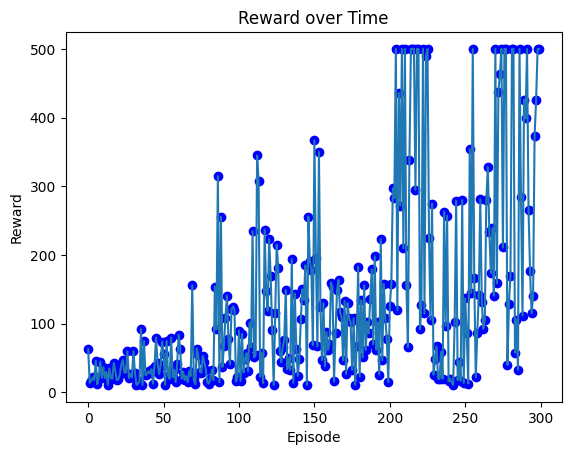

In [25]:
meta_rewards, action_list = training_loop_meta(
    NUM_EPISODES,
    max_steps=MAX_STEPS_PER_EPISODE,
    seed=SEED,
 )
plot_rewards(meta_rewards)

Loaded policy + meta networks ran for 500 steps using best_cartpole_model.pth and best_meta_network.pth.


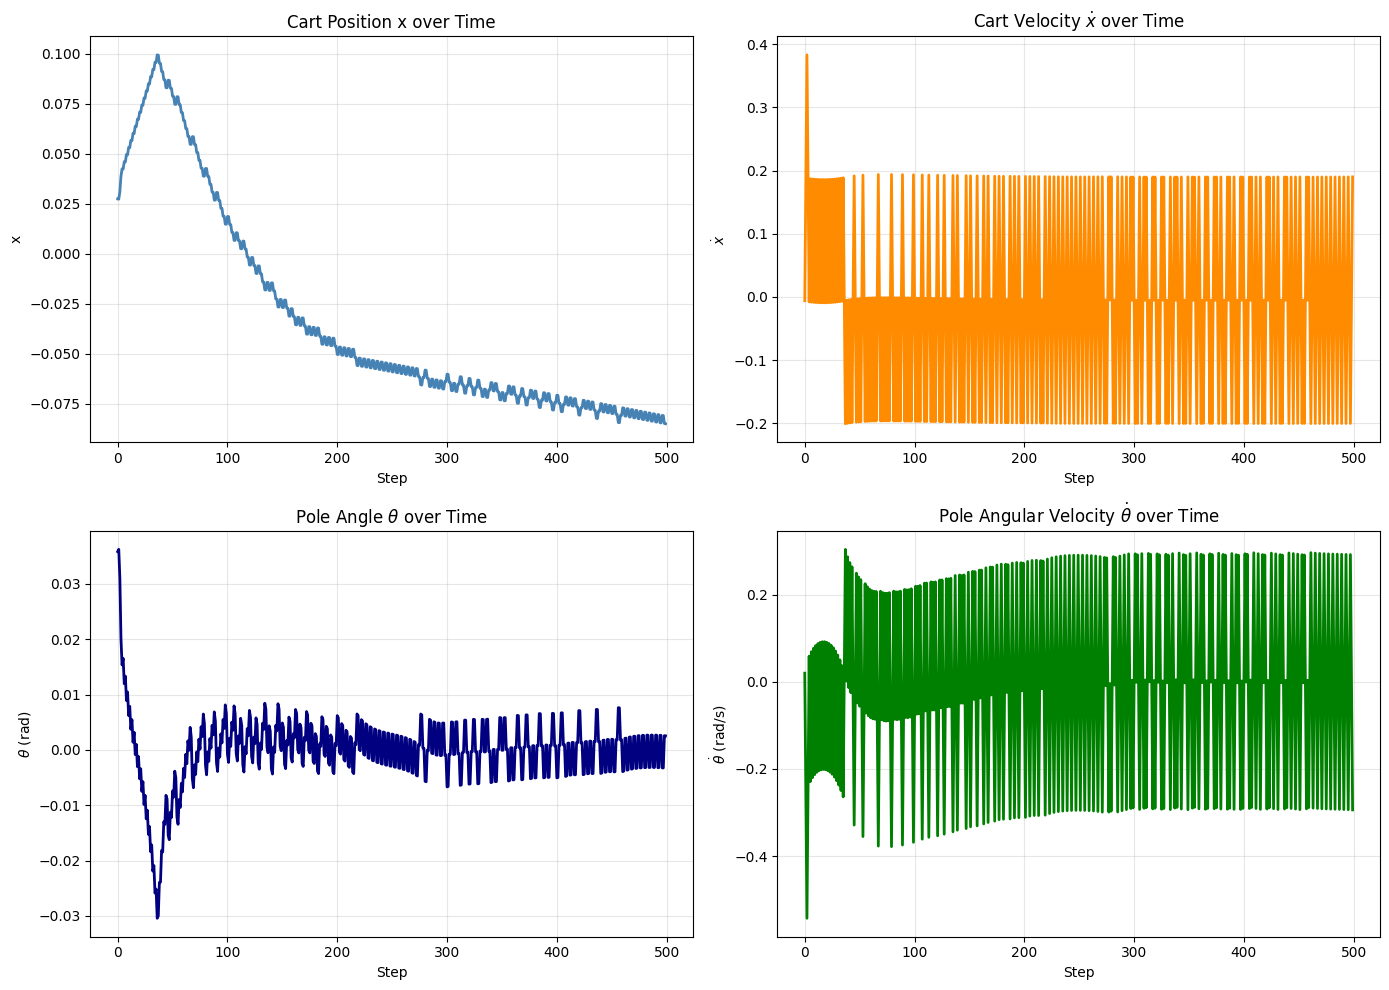

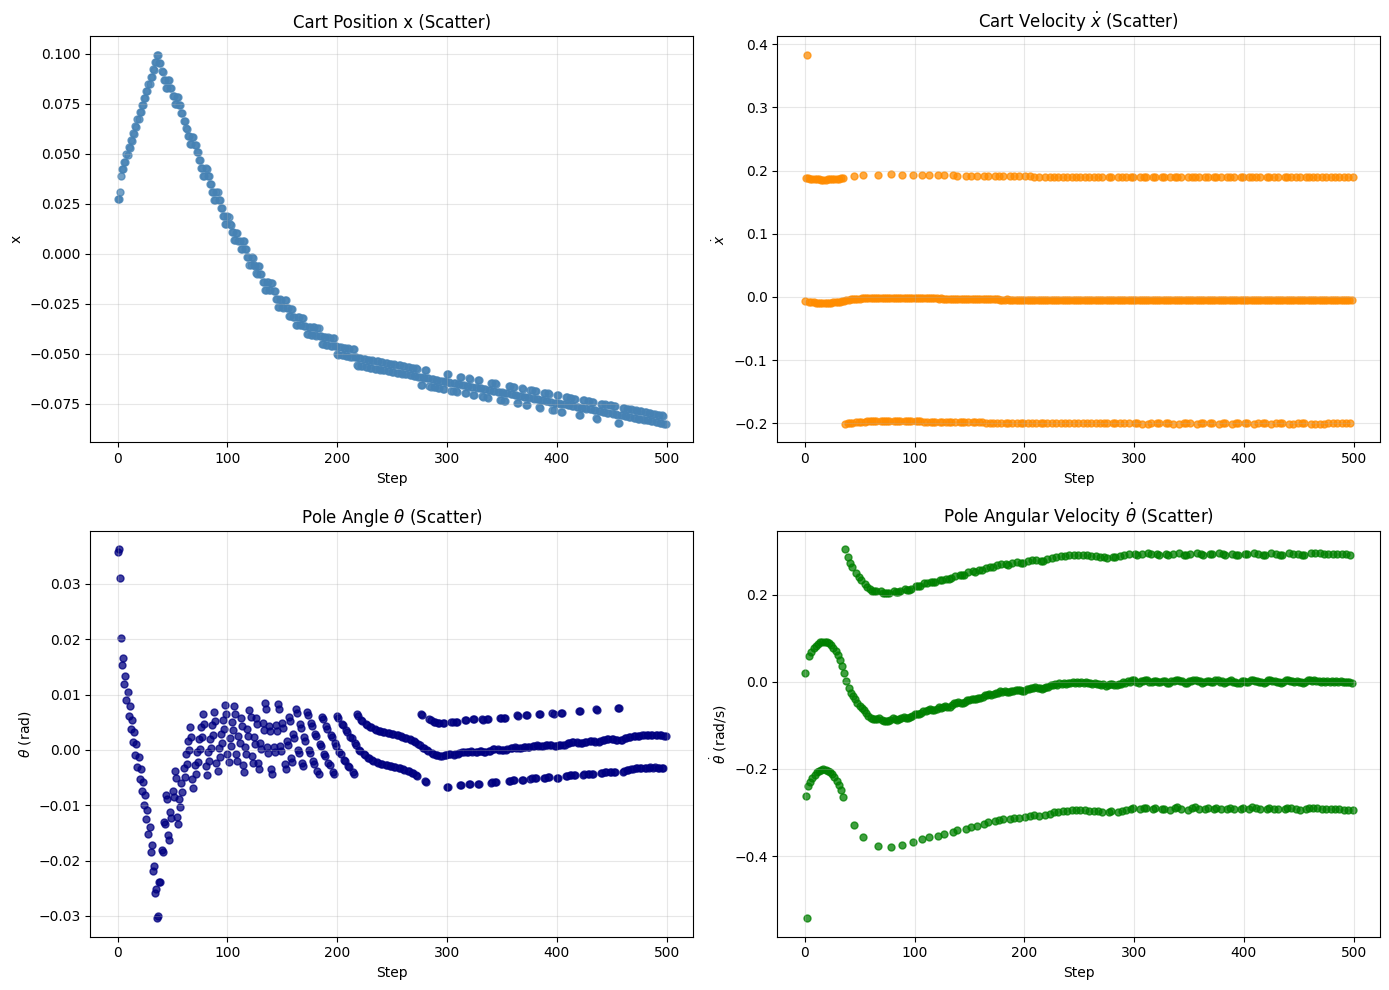

{'step': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  1

In [ ]:

from pathlib import Path

POLICY_PATH = Path("best_cartpole_model.pth")
META_PATH = Path("best_meta_network.pth")


# Policy + env rebuild ensures clean evaluation state.
eval_policy, _, _, _, eval_device, eval_env = original_network.build_model()
eval_policy.load_state_dict(torch.load(POLICY_PATH, map_location=eval_device))
eval_policy.eval()

meta_eval_net, _ = meta_network.build_model(meta_input_dim)
meta_eval_net.to(device)
meta_eval_net.load_state_dict(torch.load(META_PATH, map_location=device))
meta_eval_net.eval()

episode_trace = {
    "step": [],
    "action": [],
    "x": [],
    "x_dot": [],
    "theta": [],
    "theta_dot": [],
    "env_reward": [],
    "meta_reward": [],
    "combined_reward": [],
    "cum_env_reward": [],
    "cum_combined_reward": [],
}

state, _ = eval_env.reset(seed=SEED)
done = False
step = 0
cum_env_reward = 0.0
cum_combined_reward = 0.0

while not done and step < 500:
    x, x_dot, theta, theta_dot = state
    processed_state = original_network.process_state(state)
    action = original_network.select_action(
        processed_state,
        eval_policy,
        eval_device,
        epsilon=0.0,
        env=eval_env,
    )

    next_state, reward, terminated, truncated, _ = eval_env.step(action)
    shaped_reward = meta_network.select_action(
        processed_state,
        action,
        reward,
        meta_eval_net,
        device,
        epsilon=0.0,
        input_dim=meta_input_dim,
        return_features=False,
    )
    combined_reward = reward + shaped_reward

    cum_env_reward += reward
    cum_combined_reward += combined_reward

    episode_trace["step"].append(step)
    episode_trace["action"].append(action)
    episode_trace["x"].append(x)
    episode_trace["x_dot"].append(x_dot)
    episode_trace["theta"].append(theta)
    episode_trace["theta_dot"].append(theta_dot)
    episode_trace["env_reward"].append(reward)
    episode_trace["meta_reward"].append(shaped_reward)
    episode_trace["combined_reward"].append(combined_reward)
    episode_trace["cum_env_reward"].append(cum_env_reward)
    episode_trace["cum_combined_reward"].append(cum_combined_reward)

    state = next_state
    done = terminated or truncated
    step += 1

episode_length = len(episode_trace["step"])
print(f"Loaded policy + meta networks ran for {episode_length} steps using {POLICY_PATH.name} and {META_PATH.name}.")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

axes[0].plot(episode_trace["step"], episode_trace["x"], color="steelblue", linewidth=2)
axes[0].set_title("Cart Position x over Time")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("x")

axes[1].plot(episode_trace["step"], episode_trace["x_dot"], color="darkorange", linewidth=2)
axes[1].set_title("Cart Velocity $\\dot{x}$ over Time")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("$\\dot{x}$")

axes[2].plot(episode_trace["step"], episode_trace["theta"], color="navy", linewidth=2)
axes[2].set_title("Pole Angle $\\theta$ over Time")
axes[2].set_xlabel("Step")
axes[2].set_ylabel("$\\theta$ (rad)")

axes[3].plot(episode_trace["step"], episode_trace["theta_dot"], color="green", linewidth=2)
axes[3].set_title("Pole Angular Velocity $\\dot{\\theta}$ over Time")
axes[3].set_xlabel("Step")
axes[3].set_ylabel("$\\dot{\\theta}$ (rad/s)")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter-only view to see individual state samples without connecting lines.
fig_scatter, axes_scatter = plt.subplots(2, 2, figsize=(14, 10))
axes_scatter = axes_scatter.flatten()

axes_scatter[0].scatter(episode_trace["step"], episode_trace["x"], color="steelblue", s=25, alpha=0.75)
axes_scatter[0].set_title("Cart Position x (Scatter)")
axes_scatter[0].set_xlabel("Step")
axes_scatter[0].set_ylabel("x")

axes_scatter[1].scatter(episode_trace["step"], episode_trace["x_dot"], color="darkorange", s=25, alpha=0.75)
axes_scatter[1].set_title("Cart Velocity $\\dot{x}$ (Scatter)")
axes_scatter[1].set_xlabel("Step")
axes_scatter[1].set_ylabel("$\\dot{x}$")

axes_scatter[2].scatter(episode_trace["step"], episode_trace["theta"], color="navy", s=25, alpha=0.75)
axes_scatter[2].set_title("Pole Angle $\\theta$ (Scatter)")
axes_scatter[2].set_xlabel("Step")
axes_scatter[2].set_ylabel("$\\theta$ (rad)")

axes_scatter[3].scatter(episode_trace["step"], episode_trace["theta_dot"], color="green", s=25, alpha=0.75)
axes_scatter[3].set_title("Pole Angular Velocity $\\dot{\\theta}$ (Scatter)")
axes_scatter[3].set_xlabel("Step")
axes_scatter[3].set_ylabel("$\\dot{\\theta}$ (rad/s)")

for ax in axes_scatter:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

episode_trace